# Tech how-to: Build your own expected-goals model

This how-to guides you through the process of building your own expected-goals model using popular data science and machine learning tools like Pandas, XGBoost, and scikit-learn. In this how-to, we discuss the following steps:
1. Loading the data
2. Preparing the data
3. Constructing examples and datasets
4. Learning a model
5. Evaluating the model

As part of this how-to, we release an artificial but realistic shots dataset containing information on 127,643 shots. To represent the shots, we adopt the SPADL representation, which we introduce in more detail in the following paper:


In [1]:
%load_ext autoreload
%autoreload 2

# Import standard modules
import os
import sys

# Import Pandas library
import pandas as pd

# Import XGBoost classifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Import scikit-learn functions
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Import scikit-plot functions
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_calibration_curve

# Import SciPy function
from scipy.spatial import distance

## Load the dataset

For the purpose of this how-to, we constructed an artificial but realistic shots dataset containing information on 127,643 shots. For each shot, the dataset contains the following information for the shot as well as the two actions immediately preceding the shot:
* `game_id`: a unique identifier of the game;
* `team_id`: a unique identifier of the team who performed the action;
* `player_id`: a unique identifier of the player who performed the action;
* `period`: 1 for the first half and 2 for the second half;
* `seconds`: the time elapsed in seconds since the start of the half;
* `type_id`: the identifier for the type of action;
* `type_name`: the name for the type of action;
* `body_part_id`: 0 for foot, 1 for head, 2 for other body part;
* `result`: the result of the action: 0 for failure, 1 for success;
* `start_x`: the x coordinate for the location where the action started, ranges from 0 to 105;
* `start_y`: the y coordinate for the location where the action started, ranges from 0 to 68;
* `end_x`: the x coordinate for the location where the action ended, ranges from 0 to 105;
* `end_y`: the y coordinate for the location where the action ended, ranges from 0 to 68.

The prefix `action` refers to the shot, whereas the prefixes `action1` and `action2` refer to the last and one-but-last action prior to the shot.

The mapping between the `type_id` and `type_name` values is as follows:
* 0: pass
* 1: cross
* 2: throw in
* 3: freekick crossed
* 4: freekick short
* 5: corner crossed
* 6: corner short
* 7: take on
* 8: foul
* 9: tackle
* 10: interception
* 11: shot
* 12: shot penalty
* 13: shot freekick
* 14: keeper save
* 18: clearance
* 21: dribble
* 22: goalkick

In [2]:
df_dataset = pd.read_parquet('data/event_raw/shots.parquet')

In [3]:
number_of_shots = len(df_dataset)

print('Our dataset contains {} shots.'.format(number_of_shots))

Our dataset contains 82824 shots.


## Normalize the location features

In order to help the learning algorithm, we rescale the location features from their original scales to a normalized scale ranging from 0 to 1. More specifically, we divide the x coordinates by 105 and the y coordinates by 68.

In [4]:
df_dataset= df_dataset[['goal', 'shot_type_name','strong_foot',
       'body_part_name', 'assist_type', 'pass_height_name', 'visible_angle', 'distance_to_goal',
       'distance_visible_angle', 'shot_one_on_one',
       'shot_open_goal', 'under_pressure']]


In [5]:
# Convert boolean columns to integer
bool_cols = ['goal', 'strong_foot', 'shot_one_on_one', 'shot_open_goal', 'under_pressure']
df_dataset[bool_cols] = df_dataset[bool_cols].astype(int)

# Fill missing values in pass_height_name with 'Unknown'
df_dataset['pass_height_name'].fillna('Unknown', inplace=True)

# Define categorical columns and their categories
categorical_cols = ['shot_type_name', 'body_part_name', 'assist_type', 'pass_height_name']
categories = [['open_play', 'direct_set_piece', 'free_kick', 'throw_in', 'corner'],
              ['Right Foot', 'Left Foot', 'Other'],
              ['pass', 'nan', 'direct'],
              ['High Pass', 'Ground/ Low Pass', 'Unknown']]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(categories=categories), categorical_cols),
        ('imputer', SimpleImputer(strategy='mean'), ['visible_angle', 'distance_to_goal', 'distance_visible_angle'])
    ])

# Fit and transform the data
X = preprocessor.fit_transform(df_dataset)

# Convert the result back to DataFrame (optional)
column_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=categorical_cols)
column_names = list(column_names) + ['visible_angle', 'distance_to_goal', 'distance_visible_angle']
df = pd.DataFrame(X, columns=column_names)

In [6]:
X = df
y = df_dataset.goal

### Split the dataset into a train set and a test set
We train our expected-goals model on 90% of the data and evaluate the model on the remaining 10% of the data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

## Learn the model
We learn our expected-goals model using the XGBoost algorithm, which is a popular algorithm in machine learning competitions like Kaggle. The algorithm is particularly appealing as it requires minimal parameter tuning to provide decent performance on many standard machine learning tasks.

[Visit the XGBoost website for more information](http://xgboost.readthedocs.io/en/latest/model.html)

We train an XGBoost classifier on our train set. We train 100 trees and set their maximum depth to 4.

In [8]:
classifier = XGBClassifier(objective='binary:logistic', max_depth=4, n_estimators=100)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluate the model
We evaluate the accuracy of our expected-goals model by making predictions for the shots in our test set.

### Predict the test examples

In [9]:
# For each shot, predict the probability of the shot resulting in a goal
y_pred = classifier.predict_proba(X_test)

### Compute area under the curve: receiver operating characteristic (AUC-ROC)
To measure the accuracy of our expected-goals model, we compute the AUC-ROC obtained on the test set. The values for the AUC-ROC metric range from 0 to 1. The higher the AUC-ROC value is, the better the classifier is, where an AUC-ROC value of 0.50 corresponds to random guessing. That is, if we randomly predicted whether a shot results in a goal or not, we would obtain an AUC-ROC of 0.50.

In [10]:
y_total = y_train.count()
y_positive = y_train.sum()

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))

The training set contains 74541 examples of which 7571 are positives.


In [11]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))

Our classifier obtains an AUC-ROC of 0.770839914228777.


### Compute area under the curve: precision-recall (AUC-PR)
Since the AUC-ROC metric is susceptible to class imbalance (i.e., the number of positive examples is much lower or higher than the number of negative examples), we also compute the AUC-PR obtained on the test set. The values for the AUC-PR metric range from 0 to 1 too. The higher the AUC-PR value is, the better the classifier is. Unlike AUC-ROC, however, the value for random guessing does not necessarily correspond to 0.50 for imbalanced classes, but corresponds to the ratio of positive examples in the train set.

In [12]:
auc_pr_baseline = y_positive / y_total

print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))

The baseline performance for AUC-PR is 0.1015682644450705.


In [13]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.325327724182043.


### Plot AUC-ROC curve

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

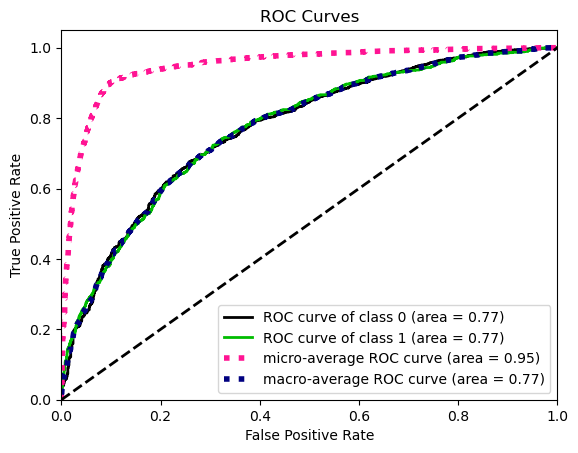

In [14]:
plot_roc(y_test, y_pred)

### Plot AUC-PR curve

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

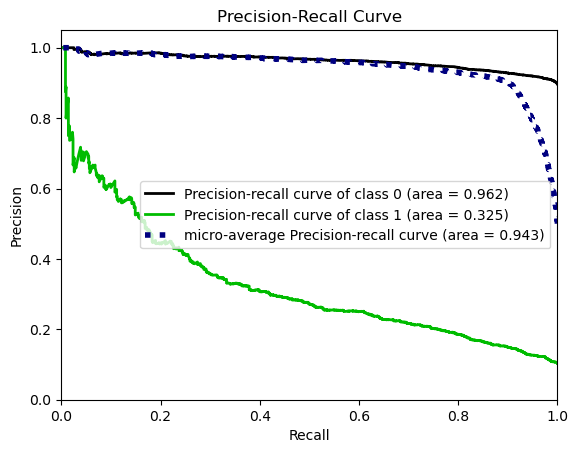

In [15]:
plot_precision_recall(y_test, y_pred)

### Plot calibration curve
We plot a calibration curve to investigate how well our expected-goals model is calibrated. The plot shows the mean predicted value on the horizontal axis and the fraction of covered positive examples on the vertical axis.

<Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

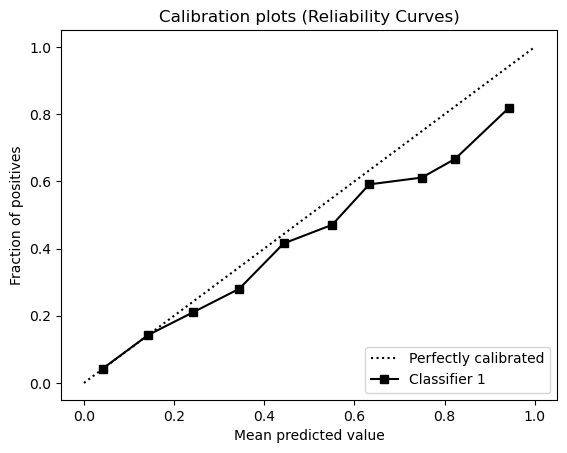

In [16]:
plot_calibration_curve(y_test, [y_pred])

## Optional: Perform grid search to find optimal parameters

In [17]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'objective': ['binary:logistic'],
    'max_depth': [4, 5, 6],
    'n_estimators': [100, 250, 500]
}

classifier = XGBClassifier()
classifier = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', verbose=2)
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END max_depth=4, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END max_depth=4, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END max_depth=4, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END max_depth=4, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END max_depth=4, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END max_depth=4, n_estimators=250, objective=binary:logistic; total time=   0.3s
[CV] END max_depth=4, n_estimators=250, objective=binary:logistic; total time=   0.3s
[CV] END max_depth=4, n_estimators=250, objective=binary:logistic; total time=   0.3s
[CV] END max_depth=4, n_estimators=250, objective=binary:logistic; total time=   0.4s
[CV] END max_depth=4, n_estimators=250, objective=binary:logistic; total time=   0.3s
[CV] END max_depth=4, n_estimators=500, objective=binary:logistic; total time=  

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [4, 5, 6],
                         'n_estimators': [100, 250, 500],
                         'objective': ['binary:logistic']},
             scoring='roc_auc', verbose=2)

In [18]:
classifier.best_params_

{'max_depth': 4, 'n_estimators': 100, 'objective': 'binary:logistic'}